# Introduction

This workbook fits a Gaussian Process model to the Random and Sobol data. 

In [4]:
import GPy
import pandas as pd
import patsy as pt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import re
import pymc3 as pm
import matplotlib.ticker as tk

import pickle

In [5]:
mod1 = pickle.load(open('results/all_chi_bayesian_model.p', 'rb'))
trace1 = mod1['trace']

mod2 = pickle.load(open('results/ppo_tor_bayesian_model.p', 'rb'))
trace2 = mod2['trace']
trace1 = pd.DataFrame({x : trace1.get_values(x) for x in trace1.varnames if x[-5:]!='log__'})
trace2 = pd.DataFrame({x : trace2.get_values(x) for x in trace2.varnames if x[-5:]!='log__'})
trace1['Model'] = '9'
trace2['Model'] = '6'
df_trace = trace1

# pd.concat([trace1, trace2], axis=0, sort=True)


In [6]:
df_trace.rename(columns={'l_basiskappa_angle': r'$\kappa$ angle', 'l_basisca_cont': r'$C \alpha$ contact', 
                        'l_basisclose-h_cont': 'Heavy contact', 'l_basisclose_cont': 'Closest contact', 
                        'l_basisdrid': 'DRID', 'l_n_s': '$n$', 'l_t_s': r'$\tau$', 
                        'l_basishb_pairs': 'BH distance', 'l_basisppo_tor': 'Backbone torsions', 
                        'l_basisall_tor': 'All torsions', 'l_basisalpha_angle': r'$C \alpha$ torsion', 
                        'l_m_s': '$m$', 'eta': r'$\eta$', 'sigma_n': r'$\sigma_n$'}, inplace=True)


len_labs = [x for x in list(df_trace.columns) if x not in [r'$\eta$', r'$\sigma_n$', 'Model']]

relevance = pd.DataFrame(1/(df_trace.loc[:, len_labs].values+1), columns=len_labs)
relevance.loc[:, 'Model'] = df_trace.loc[:, 'Model'].values
relevance_m = relevance.melt(id_vars=['Model'], var_name='Hyperparameter', value_name='Relevance')
y_order = relevance_m.loc[relevance_m['Model']=='9', :].groupby('Hyperparameter').median().reset_index().sort_values(by='Relevance', ascending=False)['Hyperparameter'].values
cont_hyperparams = [r'$\tau$', r'$m$', r'$n$']
y_order = [x for x in y_order if x not in cont_hyperparams]
y_order =cont_hyperparams +  y_order

In [7]:
cols = [np.array(list(x)+[1]) for x in sns.color_palette('colorblind', 3)]
cols = cols + sns.light_palette(color=(0.835, 0.369, 0.0), n_colors=18, reverse=True)


In [8]:
x = np.random.random(1000)
np.quantile(x, [0.5, 0.7])

array([0.49859815, 0.70257602])

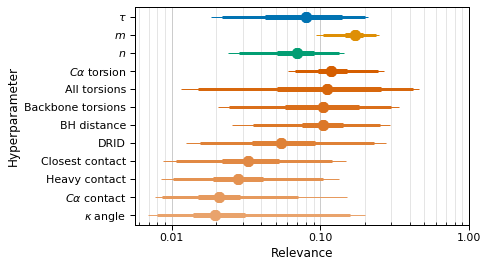

In [9]:
lws = [1, 3, 5]
qs = [0.01, 0.025, 0.25]
with sns.plotting_context('paper', font_scale=1.25):
#     sns.set_style('whitegrid')
    fig, ax = plt.subplots(1)
    for i, var in enumerate(y_order): 
        x = relevance.loc[:, var].values
        for j in range(len(lws)):
            lb = np.median(x)-np.quantile(x, qs[j])
            ub = -np.median(x)+np.quantile(x, 1-qs[j])
            ax.errorbar(y=[var], x=np.median(x), xerr=np.array([[lb], [ub]]), 
                        marker='o', lw=lws[j], color=cols[i], ms=10)

    ax.set_xscale('log')
    lims = ax.get_xlim()
    ax.set_xlim(lims[0], 1)
    ax.invert_yaxis()
    ax.xaxis.set_major_formatter(tk.StrMethodFormatter('{x:4.2f}'))
    ax.xaxis.set_minor_locator(tk.LogLocator(base=10.0, subs='auto', numdecs=4))
    ax.tick_params(which='minor', axis='x', bottom=True, direction='in')
    ax.grid(True, which='minor', axis='x', alpha=0.4)
    ax.grid(True, which='major', axis='x', alpha=0.8)
    ax.grid(False, which='major', axis='y')
    ax.grid(False, which='minor', axis='y')
    
    ax.set_xlabel('Relevance')
    ax.set_ylabel('Hyperparameter')
    plt.savefig('figures/mod_9_gp_bayes_relevance.png', dpi=450, bbox_inches='tight')

In [11]:
df_trace.filter(regex='')

,$\eta$,All torsions,$C \alpha$ torsion,$C \alpha$ contact,Heavy contact,Closest contact,DRID,BH distance,$\kappa$ angle,Backbone torsions,$\tau$,$m$,$n$,$\sigma_n$,Model
0,1.532244,11.795539,9.940804,62.288063,30.892447,50.010261,80.350404,8.340717,93.700194,13.756282,8.734768,5.174712,15.603140,0.136421,9
1,1.469711,13.430045,6.153019,35.822987,40.631093,54.644435,23.295329,6.743586,46.181857,9.372134,10.666976,4.945122,7.980734,0.133741,9
2,0.857303,9.350838,10.724305,82.147925,39.153177,14.697798,16.279949,7.715314,54.254336,10.258023,7.426283,3.132299,19.362586,0.139604,9
3,0.957454,23.849483,13.517209,67.226938,76.453587,12.418255,17.820544,7.143092,48.337970,9.800051,7.067067,3.741983,12.883006,0.139121,9
4,0.950290,2.809047,9.797402,75.937407,74.659097,45.477632,27.156103,10.874970,45.383538,4.979038,9.934077,2.957526,14.295872,0.140370,9


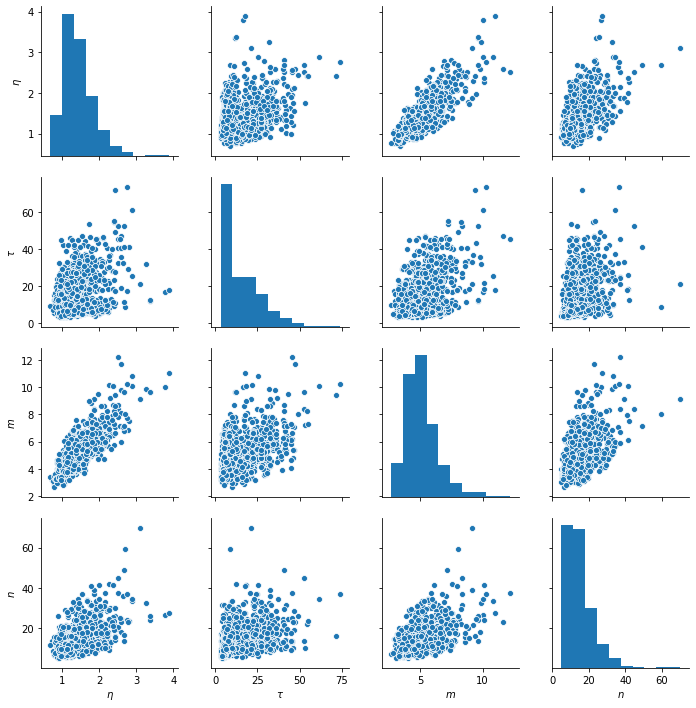

In [20]:
sns.pairplot(df_trace.loc[:, [r'$\eta$', r'$\tau$', r'$m$', r'$n$']].sample(frac=0.5))